# 12. Local features + Homography – localizing objects

In [19]:
import cv2
import matplotlib.pyplot as plt
import numpy as np


def display_image(img, title=""):
    plt.figure()
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")
    plt.show()

Develop a program that tries to detect a given object in an image, delineating the countour of the object in the image
(figure 4). Use one of the methods used in the previous exercises to extract and match keypoints, and the functions
`cv::findHomography()`, to find the transform between matched keypoints, and `cv::perspectiveTransform()`, to
map the points of the contour of the object to the imag

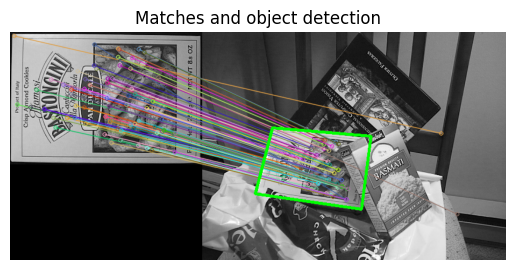

In [27]:
OBJECT_PATH = "../../images/match_box01a_1.png"
SCENE_PATH = "../../images/match_box01a_2.png"

image_object = cv2.imread(OBJECT_PATH, cv2.IMREAD_GRAYSCALE)
image_scene = cv2.imread(SCENE_PATH, cv2.IMREAD_GRAYSCALE)

# -- Step 1: Detect the keypoints using SIFT Detector, compute the descriptors

detector = cv2.SIFT_create()
keypoints_obj, descriptors_obj = detector.detectAndCompute(image_object, None)
keypoints_scene, descriptors_scene = detector.detectAndCompute(image_scene, None)

# -- Step 2: Matching descriptor vectors with a FLANN based matcher
# Since SURF is a floating-point descriptor NORM_L2 is used

matcher = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_FLANNBASED)
knn_matches = matcher.knnMatch(descriptors_obj, descriptors_scene, 2)

# -- Filter matches using the Lowe's ratio test
ratio_thresh = 0.75
good_matches = []
for m, n in knn_matches:
    if m.distance < ratio_thresh * n.distance:
        good_matches.append(m)


# -- Draw matches
image_matches = np.empty(
    (
        max(image_object.shape[0], image_scene.shape[0]),
        image_object.shape[1] + image_scene.shape[1],
        3,
    ),
    dtype=np.uint8,
)
cv2.drawMatches(
    image_object,
    keypoints_obj,
    image_scene,
    keypoints_scene,
    good_matches,
    image_matches,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
)

obj = np.empty((len(good_matches), 2), dtype=np.float32)
scene = np.empty((len(good_matches), 2), dtype=np.float32)
for i, elem in enumerate(good_matches):
    # -- Get the keypoints from the good matches
    obj[i, 0] = keypoints_obj[elem.queryIdx].pt[0]
    obj[i, 1] = keypoints_obj[elem.queryIdx].pt[1]
    scene[i, 0] = keypoints_scene[elem.trainIdx].pt[0]
    scene[i, 1] = keypoints_scene[elem.trainIdx].pt[1]


H, _ = cv2.findHomography(obj, scene, cv2.RANSAC)

# -- Get the corners from the image_1 ( the object to be "detected" )
obj_corners = np.empty((4, 1, 2), dtype=np.float32)
obj_corners[0, 0, 0] = 0
obj_corners[0, 0, 1] = 0
obj_corners[1, 0, 0] = image_object.shape[1]
obj_corners[1, 0, 1] = 0
obj_corners[2, 0, 0] = image_object.shape[1]
obj_corners[2, 0, 1] = image_object.shape[0]
obj_corners[3, 0, 0] = 0
obj_corners[3, 0, 1] = image_object.shape[0]
scene_corners = cv2.perspectiveTransform(obj_corners, H)


# -- Draw lines between the corners (the mapped object in the scene - image_2 )
cv2.line(
    image_matches,
    (int(scene_corners[0, 0, 0] + image_object.shape[1]), int(scene_corners[0, 0, 1])),
    (int(scene_corners[1, 0, 0] + image_object.shape[1]), int(scene_corners[1, 0, 1])),
    (0, 255, 0),
    4,
)
cv2.line(
    image_matches,
    (int(scene_corners[1, 0, 0] + image_object.shape[1]), int(scene_corners[1, 0, 1])),
    (int(scene_corners[2, 0, 0] + image_object.shape[1]), int(scene_corners[2, 0, 1])),
    (0, 255, 0),
    4,
)
cv2.line(
    image_matches,
    (int(scene_corners[2, 0, 0] + image_object.shape[1]), int(scene_corners[2, 0, 1])),
    (int(scene_corners[3, 0, 0] + image_object.shape[1]), int(scene_corners[3, 0, 1])),
    (0, 255, 0),
    4,
)
cv2.line(
    image_matches,
    (int(scene_corners[3, 0, 0] + image_object.shape[1]), int(scene_corners[3, 0, 1])),
    (int(scene_corners[0, 0, 0] + image_object.shape[1]), int(scene_corners[0, 0, 1])),
    (0, 255, 0),
    4,
)
# -- Show detected matches
display_image(image_matches, "Matches and object detection")